## Problem 1

Suppose whether it is sunny or not in Charlottesville depends on the weather of the last three days. Show how this can be modeled as a Markov chain.

### Answer:

Suppose a weather value of 1 means sunny and 0 means rain. We define the state as the vector weather values of the last three days. Let $x_t$ be this vector at time $t$, so $x_t = (0,0,1)$ means that it rained at times $t-2$ and $t-1$ and was sunny at time $t$. Thus each $x_t, t = 1, \ldots, T$ takes one of 8 vector values $(i_1,i_2,i_3), i_j \in \{0,1\}, j =1,2,3$. Since the weather today depends on the weather values for the last three days, then $Pr(x_t= k_t| x_{t-1} = k_{t-1}, \ldots, x_1 = k_1) = Pr(x_t= k_t| x_{t-1} = k_{t-1})$ for $k_m \in (i_1,i_2,i_3), i_j \in \{0,1\}, j =1,2,3$. This means $x_t, t =1, \ldots, T$ is a Markov chain.

## Problem 2

Let $X \sim N(\mu, \Sigma)$ where $\mu = (1,1)$ and 

$\begin{equation*}
\Sigma = 
\begin{bmatrix}
1 & -0.5 \\
-0.5 & 1
\end{bmatrix}
\end{equation*}$

Use  numpy and scipy to implement a Gibbs sampling algorithm for this 2D Gaussian. Show three runs of you algorithm with 100 samples past burn-in  as 1D scatter plots in each of the two dimensions overlaid on the plots of the actual marginal distributions.

### Answer:

Let 
$p(\mathbf{x})$  be the target distribution and recall that it is a bivariate Gaussian. This means that 

$\begin{align*}
    p(\mathbf{x}) & \propto \exp \left( -\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) \right) \\
    & = \exp \left( -\frac{1}{2} \begin{bmatrix}x_1 - \mu_1 & x_2 - \mu_2\end{bmatrix} \begin{bmatrix}\Sigma^{-1}_{11} & \Sigma^{-1}_{12} \\ \Sigma^{-1}_{21} & \Sigma^{-1}_{22}\end{bmatrix} \begin{bmatrix}x_1 - \mu_1 \\ x_2 - \mu_2 \\ \end{bmatrix} \right)
\end{align*}$

To simplify the notation let  $\alpha = x_1 - \mu_1$ and $\beta = x_2 - \mu_2$, so:

$\begin{align*}
    & = \exp \left( -\frac{1}{2} \begin{bmatrix}\alpha & \beta\end{bmatrix} \begin{bmatrix}\Sigma^{-1}_{11} & \Sigma^{-1}_{12} \\ \Sigma^{-1}_{21} & \Sigma^{-1}_{22}\end{bmatrix} \begin{bmatrix}\alpha  \\ \beta \\ \end{bmatrix} \right) \\
    & =  \exp \left( -\frac{1}{2} \begin{bmatrix} \alpha \Sigma^{-1}_{11} + \beta \Sigma^{-1}_{21} &, \alpha \Sigma^{-1}_{12} + \beta \Sigma^{-1}_{22} \end{bmatrix} \begin{bmatrix}\alpha  \\ \beta \\ \end{bmatrix} \right) \\   
    & =  \exp -\frac{1}{2}\left(  \alpha(\alpha \Sigma^{-1}_{11} + \beta \Sigma^{-1}_{21}) + \beta(\alpha \Sigma^{-1}_{12} + \beta \Sigma^{-1}_{22}) \right) \\ 
    & = \exp \left( -\frac{1}{2} (\alpha^2 \Sigma^{-1}_{11} + \alpha\beta \Sigma^{-1}_{21} + \alpha\beta \Sigma^{-1}_{12} + \beta^2 \Sigma^{-1}_{22}) \right) 
\end{align*}$

So
\begin{equation} \label{eq:Gaussian}
 p(\mathbf{x})  \propto \exp \left( -\frac{1}{2} (\alpha^2 \Sigma^{-1}_{11} + \alpha\beta \Sigma^{-1}_{21} + \alpha\beta \Sigma^{-1}_{12} + \beta^2 \Sigma^{-1}_{22}) \right) 
\end{equation}


For Gibb's sampling we fix one variable and sample according to the distribution of the other. We continue through all variables. In this case there are only 2 variables. Suppose we start with $x_{1}$ then we fix $x_{2}$ and sample according to  $p(x_1 \mid x_2 = k)$ for some constant, $k$. This is a univariate Gaussian (a slice across any dimension of a multivariate Gaussian is also Gaussian). So it has the form 

\begin{equation}\label{eq:UniGaussian}
p(x_1 \mid x_2 = k)  = \frac{1}{\sigma \sqrt{2\pi}}\exp \left(\frac{-1}{2\sigma^2}(x_{1}-\mu)^2 \right)
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc3 as pm
import arviz as az
import pandas as pd
import scipy.linalg as la


az.style.use('arviz-darkgrid')

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# True mu, covariance matrix
mu = np.array( [1, 1] )
cov = np.array( [[  1, -.5],
                 [ -.5,  1]] )

# True bivariate and marginal distributions
true_p = st.multivariate_normal(mean = mu, cov=cov)
true_marginal_p_x1 = st.norm(loc = mu[0], scale = cov[0,0])
true_marginal_p_x2 = st.norm(loc = mu[1], scale = cov[1,1])

# Number of chains, although only 1 was required
M = 3

In [3]:
# Get the values for the matrix inverse of the covariance matrix (precision)

la.inv(cov)

array([[1.33333333, 0.66666667],
       [0.66666667, 1.33333333]])

Substituting the particular values of $\Sigma^{-1}$ at this stage simplifies the problem:

\begin{align}
    & = \exp \left( -\frac{1}{2} (\frac{4}{3} \alpha^2 + 2\frac{2}{3} \alpha\beta + \frac{4}{3} \beta^2 ) \right) \\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( \alpha^2 + \alpha\beta + \beta^2 ) \right) \\
\end{align}

Now, find $p(x_1 \mid x_2 = k)$, i.e., the conditional distribution of $x_1$ for some fixed value of $x_2$:

\begin{align}
    p(x_1 \mid x_2 = k) & \propto \exp \left( -\frac{1}{2} \frac{4}{3} ( \alpha^2 + \alpha\beta + \beta^2 ) \right) \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( (x_1 - \mu_1)^2 + (x_1 - \mu_1)\beta + \beta^2 ) \right) & \textrm{by substituting }\alpha \\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( (x_1 - 1)^2 + (x_1 - 1)\beta + \beta^2 ) \right) & \textrm{by substituting }\mu\\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( x_1^2 - 2x_1 + 1 + \beta x_1 - \beta + \beta^2 ) \right) \\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( x_1^2 + (\beta-2)x_1 + (\beta^2 - \beta + 1)) \right) \\
    & \propto \exp \left( -\frac{1}{2} \frac{4}{3} \left( x_1^2 + \frac{\beta-2}{2} \right)^2 + \text{Const}\right) & \textrm{by completing the square}\\
\end{align}

Where $\text{Const} = \frac{3\beta^2}{4}$. So, $p(x_1 \mid x_2 = k)$ is a univariate Gaussian, a function of the form $\exp \left(\frac{-1}{2\sigma^2}(x-\mu)^2 \right)$, for 
\begin{align}
\mu &= -\frac{\beta-2}{2} = -\frac{(k-1)-2}{2} = \frac{3-k}{2} \\
\sigma^2 &= \frac{3}{4}
\end{align}

Now, find $p(x_2 \mid x_1 = k)$ using very similar derivation:

\begin{align}
    p(x_2 \mid x_1 = k) & \propto \exp \left( -\frac{1}{2} \frac{4}{3} ( \alpha^2 + \alpha\beta + \beta^2 ) \right) \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( ( \alpha^2 + \alpha(x_2 - \mu_2) + (x_2 - \mu_2)^2 ) \right) & \textrm{by substituting }\alpha \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( ( \alpha^2 + \alpha(x_2 - 1) + (x_2 - 1)^2 ) \right) & \textrm{by substituting }\mu \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( x_2^2 - 2x_2 + 1 + \alpha x_2 - \alpha + \alpha^2   ) \right) \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( x_2^2 + (\alpha-2) x_2  + (\alpha^2 - \alpha + 1)   ) \right) \\
    & \propto \exp \left( -\frac{1}{2} \frac{4}{3} \left( x_2^2 + \frac{\alpha-2}{2} \right)^2 + \text{Const}\right) & \textrm{by completing the square}\\
\end{align}

So $p(x_2 \mid x_1 = k)$ is _also_ a univariate Gaussian, a function of the form $\exp \left(\frac{-1}{2\sigma^2}(x-\mu)^2 \right)$, for 
\begin{align}
\mu &= -\frac{\alpha-2}{2} = -\frac{(k-1)-2}{2} = \frac{3-k}{2} \\
\sigma^2 &= \frac{3}{4}
\end{align}

In [4]:
# Define the conditional distributions, as derived above.
# Note that scipy uses standard deviation, not variance, for "scale"
def p_x1_x2(x2):
    return st.norm(loc = (3-x2)/2, scale = (3/4)**.5)
def p_x2_x1(x1):
    return st.norm(loc = (3-x1)/2, scale = (3/4)**.5)

# Draw a Gibbs sample, given current state x.
# Loop over each component, sampling from the conditional distributions
def gibbs(x):
    x[0] = p_x1_x2(x[1]).rvs(1)
    x[1] = p_x2_x1(x[0]).rvs(1)
    
# Calculate Rhat to determine if the chain is converging 
def Rhat(chains):
    N = len(chains[0]) # assume all chains of equal length
    
    theta_bar_j = np.array([c.mean() for c in chains])
    theta_dbar = theta_bar_j.mean()
    
    B = N / (M-1) * ( (theta_bar_j-theta_dbar)**2 ).sum()
    
    W = np.array( [c.var() for c in chains] )
    
    varhat_theta = (1 - 1/N) * W + 1/N * B
    
    Rhat = (varhat_theta/W)**.5
    
    # return largest Rhat (Rhat is calculated for each chain)
    return max(Rhat)

In [5]:
# Pick initial values that could be almost anywhere, pretending that the true ones are unknown
init = st.cauchy()

# Initialize the chain states (just current state)
chains  = [st.norm.rvs((1,2)), 
           st.norm.rvs((1,2)), 
           st.norm.rvs((1,2))]

# Initialize the samples (include previous states)
samples = [np.array(chains[0]),
           np.array(chains[1]),
           np.array(chains[2])]
samples = [s.reshape((1,2)) for s in samples]

In [6]:
# Run until convergence is reached
i = 0
while True:
    
    # Run Gibbs sampler for each chain, one iteration
    for j in range(M):
        gibbs(chains[j])
        samples[j] = np.concatenate((samples[j], chains[j].reshape((1,2))))
       
    # Calculate the Rhat for each parameter, then take the larger of the two
    Rhat_x1 = Rhat([s[:, 0] for s in samples])
    Rhat_x2 = Rhat([s[:, 1] for s in samples])
    max_Rhat = max(Rhat_x1, Rhat_x2)

    # If it's greater than 1.2, continue iterating.
    # Otherwise, break. The variable i will be the iteration when convergence was reached
    i += 1
    print("Iteration {0}, largest Rhat = {1}".format(i, max_Rhat))   
    if max_Rhat <= 1.2:
        print("Convergence reached (Rhat <= 1.2)...")
        break

Iteration 1, largest Rhat = 1.6052500853122968
Iteration 2, largest Rhat = 1.595977626063598
Iteration 3, largest Rhat = 1.4379298859776106
Iteration 4, largest Rhat = 0.9702283162539629
Convergence reached (Rhat <= 1.2)...


In [7]:
# Generate N samples
print("Sampling...")

# Now that the three chains have converged, draw N samples from each
N = 10000
for _ in range(N):
    
    # For each chain,
    for j in range(M):
        
        # Run Gibbs sampling and store the sample
        gibbs(chains[j])
        samples[j] = np.concatenate((samples[j], chains[j].reshape((1,2))))
        
# Discard the samples from before convergence
for j in range(M):
    samples[j] = samples[j][(i+1):, :]

Sampling...


/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


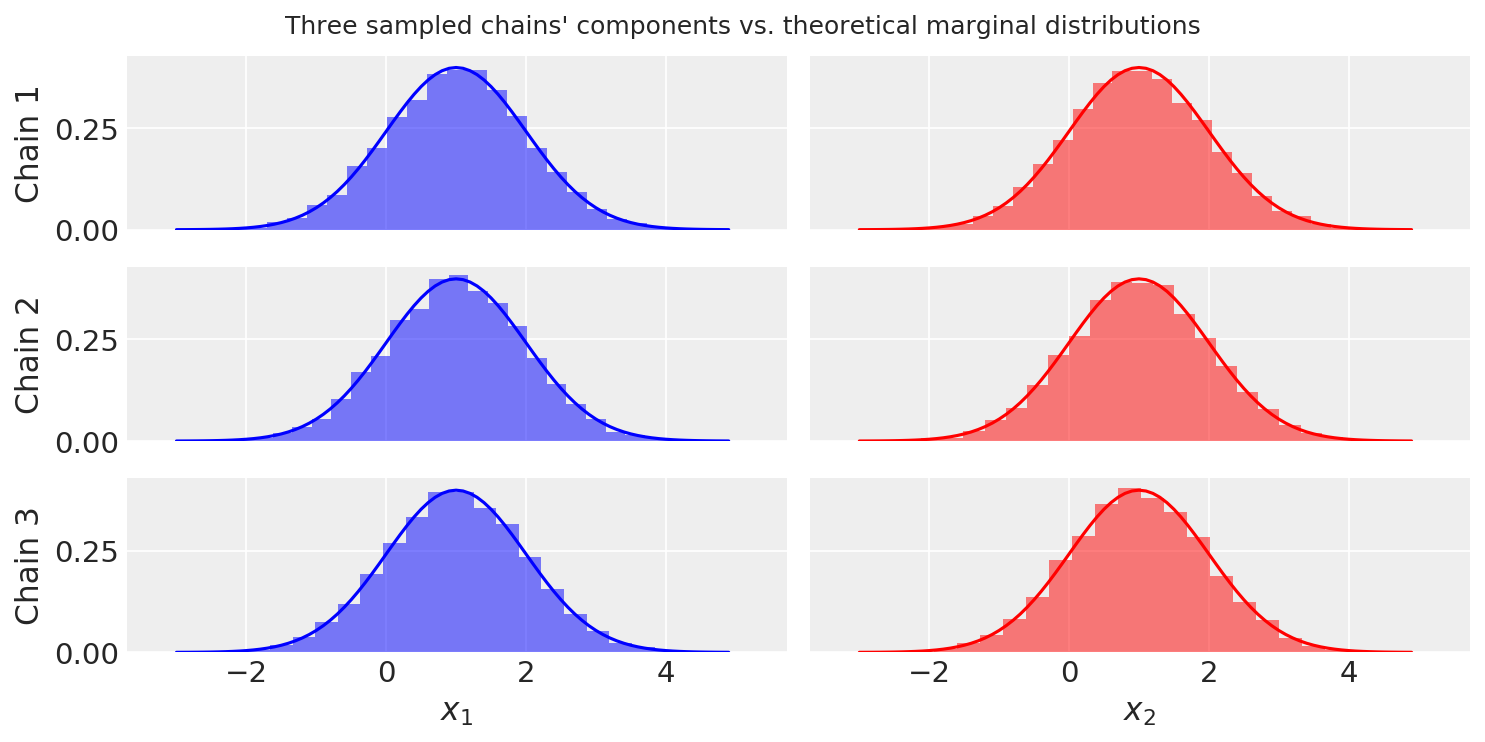

In [8]:
# Plot the three chains' samples for each variable against the true marginal distributions
# As noted two cells above ("Generate N samples..."), there are N = 10000 samples in each plot
# This is 2 orders of magnitude more than required.
# Also, burn-in was determined by when Rhat <= 1.2

support = np.arange(-3, 5, 0.1)

fig, axes = plt.subplots(nrows=3, ncols = 2, figsize=(10,5), dpi=150, sharex=True, sharey=True)
for j in range(M):
    for k, color, true_marginal in zip(range(2), ['blue', 'red'], [true_marginal_p_x1, true_marginal_p_x2]):
        
        axes[j,k].hist(samples[j][:,k], density=True, bins=25, alpha=0.5, color=color)
        axes[j,k].plot(support, true_marginal.pdf(support), color=color)
        
for k in range(2):
    axes[-1,k].set_xlabel("$x_%d$" % (k+1))
    
for j in range(M):
    axes[j,0].set_ylabel("Chain %d" % (j+1))
        
plt.suptitle("Three sampled chains' components vs. theoretical marginal distributions")
plt.tight_layout()
plt.subplots_adjust(top=.925)
plt.show()

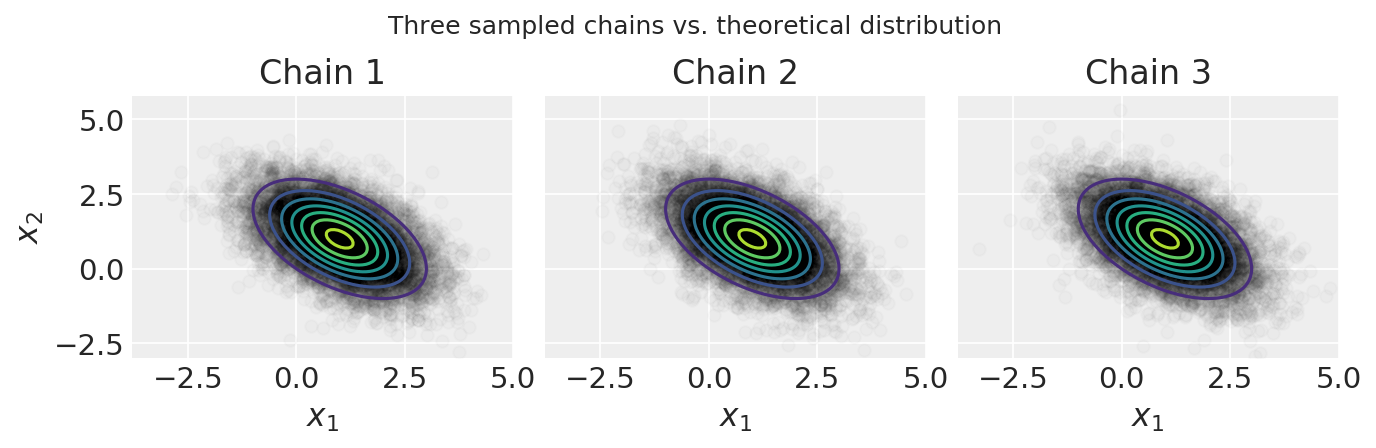

In [9]:
# For extended viewing (not required in the assignment), 
# plot each chain against the true bivariate Gaussian distribution
# Use this to check the results, in addition to the required plots (above)

n = 100
x = np.mgrid[(1-4):(1+4):(n*1j)]
y = np.mgrid[(1-4):(1+4):(n*1j)]

fig, axes = plt.subplots(nrows=1, ncols = 3, figsize=(9,3), dpi=150, sharex=True, sharey=True)
z = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        z[j, i] = true_p.pdf( (x[i], y[j]) )
            
for j in range(M):
    axes[j].scatter(samples[j][:,0], samples[j][:,1], color='black', alpha=0.015)
    axes[j].contour(x, y, z)
    axes[j].set_title("Chain %d" % (j+1))
    axes[j].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
    
plt.suptitle("Three sampled chains vs. theoretical distribution")
plt.tight_layout()
plt.subplots_adjust(top=.8)
plt.show()

## Problem 3

With the CHD data set (CHDdata.csv ) from  Homework 2 develop a sampling based estimate for the posterior distributions of the parameters in a main effects logistic regression model. Use all predictor variables in the data set and standardize all of the numeric, continuous predictors using the mean and standard deviation. 

- Use Gaussian or Cauchy priors with hyperparameters appropriate for uninformed priors and show the graphical representation of your model (you should use graphviz for this).
- Show the summary table and trace plots from the sampling and briefly say what they mean for your results.
- Provide forest plots of the parameters and discuss what these results imply for the relevant predictor variables and the overall model.

In [10]:
# Load the data

path = "/Users/donaldbrown/Dropbox/department/Classes/Data/"
file = "CHDdata.csv"
data = pd.read_csv(path+file)

# Numeric predictors
numeric_predictors = ["sbp","tobacco","ldl","adiposity","typea","obesity","alcohol","age"]
n = data.shape[0]

# Numeric, categorical predictors and response, y`

x_num = data[numeric_predictors]
x_cat = data['famhist']
y = data['chd']

all_predictors = numeric_predictors
all_predictors.append('famhist')

# No. of predictors
k = len(all_predictors)

# Standardize numeric columns, to mean 0 variance 1
mean = x_num.mean()
std = x_num.std()
x_num = np.array((x_num - mean) / std)

# Convert categorical predictor column to a dummy variable
# + 0 forces numeric type
x_cat = np.array(data['famhist'] == 'Present').reshape((n,1))

# Put them into one data matrix

X = np.concatenate((x_num, x_cat), axis = 1)


In [11]:
# Build the model with priors and run the sampling
with pm.Model() as chd_model:
    
    # Intercept term & prior
    β0 = pm.Normal('β0', mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    
    # Calculate the logit 
    μ = β0 + pm.math.dot(X,β)
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=y) 
    
    # Sample
    trace_main = pm.sample(10000, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [β, β0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 72 seconds.


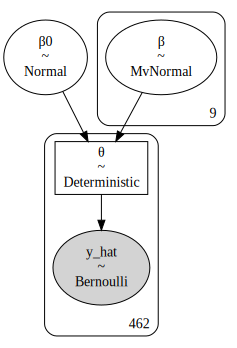

In [12]:
# The graphical model
pm.model_to_graphviz(chd_model)

In [13]:
# Results in table
with chd_model:
    main_idata = az.from_pymc3(trace_main)
az.summary(main_idata, var_names=['β0','β'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0,-1.23,0.16,-1.53,-0.93,0.0,0.0,89180.44,87935.04,89251.28,65346.02,1.0
β[0],0.14,0.12,-0.09,0.35,0.0,0.0,129248.52,74229.54,129231.37,59752.54,1.0
β[1],0.37,0.12,0.14,0.60,0.0,0.0,114922.09,100898.51,115226.37,63105.79,1.0
β[2],0.37,0.12,0.14,0.60,0.0,0.0,126146.90,106858.89,126331.33,59614.55,1.0
β[3],0.15,0.22,-0.28,0.56,0.0,0.0,71633.77,52614.46,71666.69,60546.87,1.0
β[4],0.39,0.12,0.16,0.61,0.0,0.0,121568.86,107429.98,121726.01,61665.66,1.0
β[5],-0.26,0.18,-0.61,0.07,0.0,0.0,80192.07,70112.55,80185.07,64105.06,1.0
β[6],0.00,0.11,-0.20,0.21,0.0,0.0,124026.42,35501.07,124063.30,61126.18,1.0
β[7],0.66,0.17,0.33,0.99,0.0,0.0,89809.98,86907.78,89825.22,65853.86,1.0
β[8],0.87,0.22,0.45,1.28,0.0,0.0,92625.32,90398.65,92628.57,67243.43,1.0


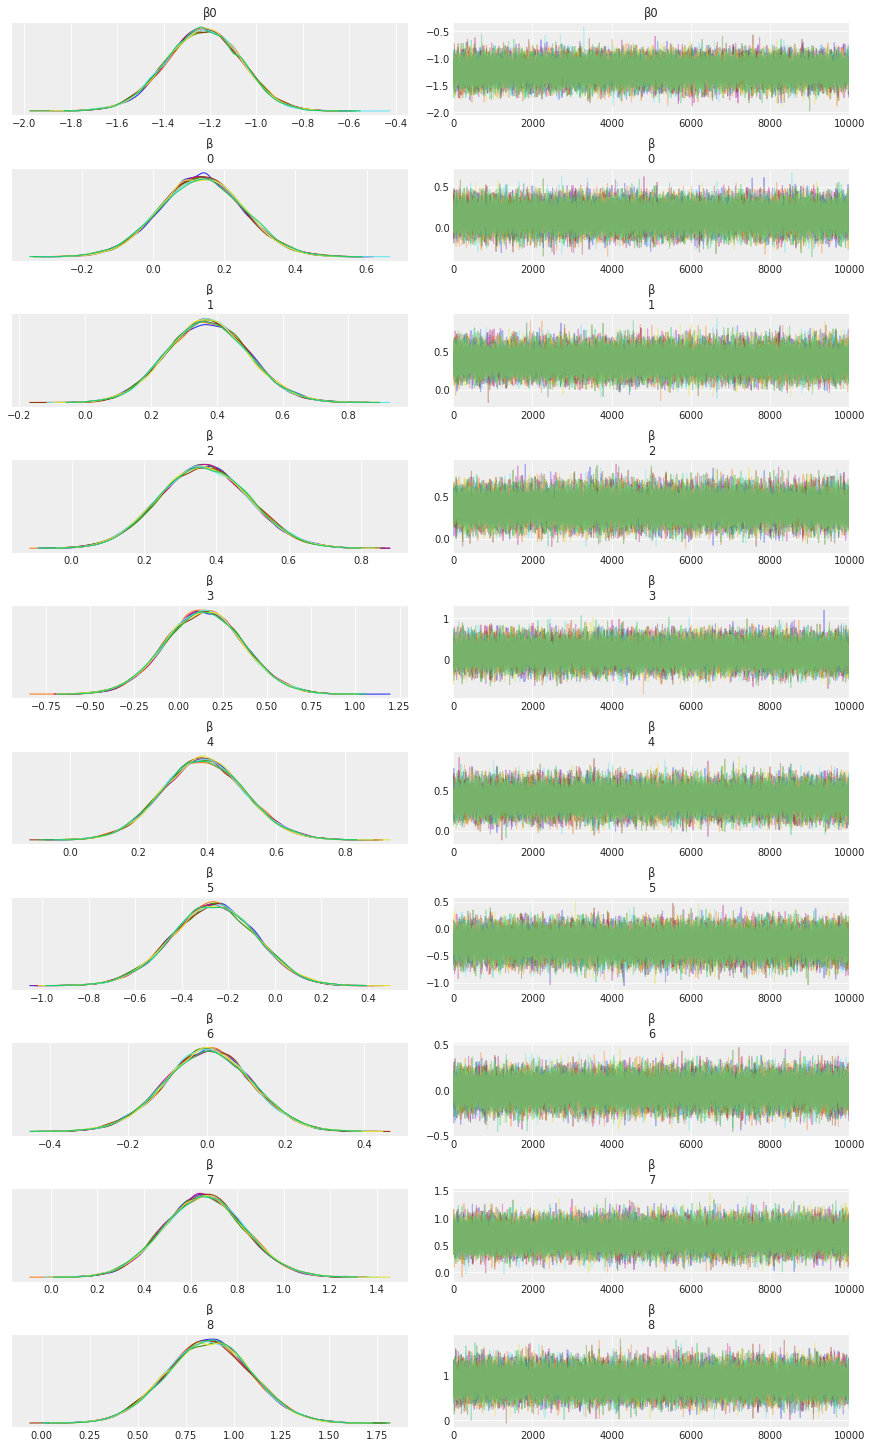

In [14]:
# Trace plots
with chd_model:
    az.plot_trace(trace_main, var_names=['β0','β'])

The trace plots show good covergence and the $\hat{R} = 1$ for all parameters. So we can be confident in our posterior estimates.

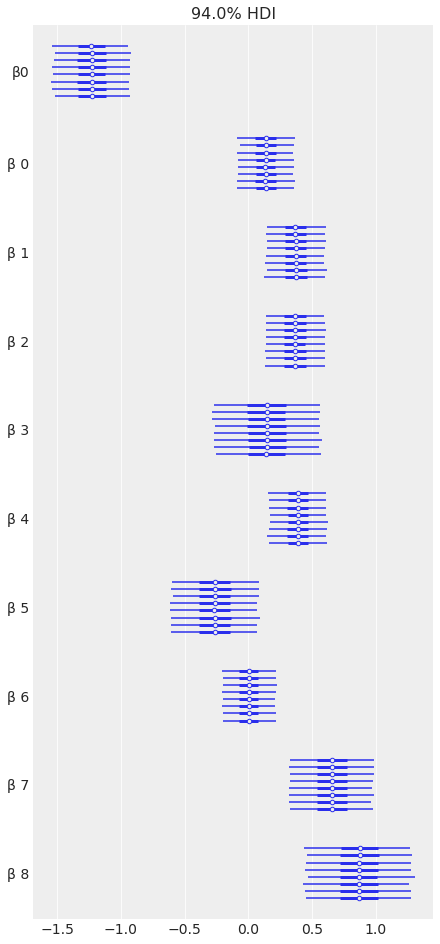

In [15]:
with chd_model:
    pm.forestplot(trace_main, var_names=['β0','β'])

In [16]:
pd.DataFrame(all_predictors)

,0
0,sbp
1,tobacco
2,ldl
3,adiposity
4,typea
5,obesity
6,alcohol
7,age
8,famhist


Based on the forest plots, the variables sdp, adiposity, obesity and alcohol are not significant in the main effects model at p < 0.05

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


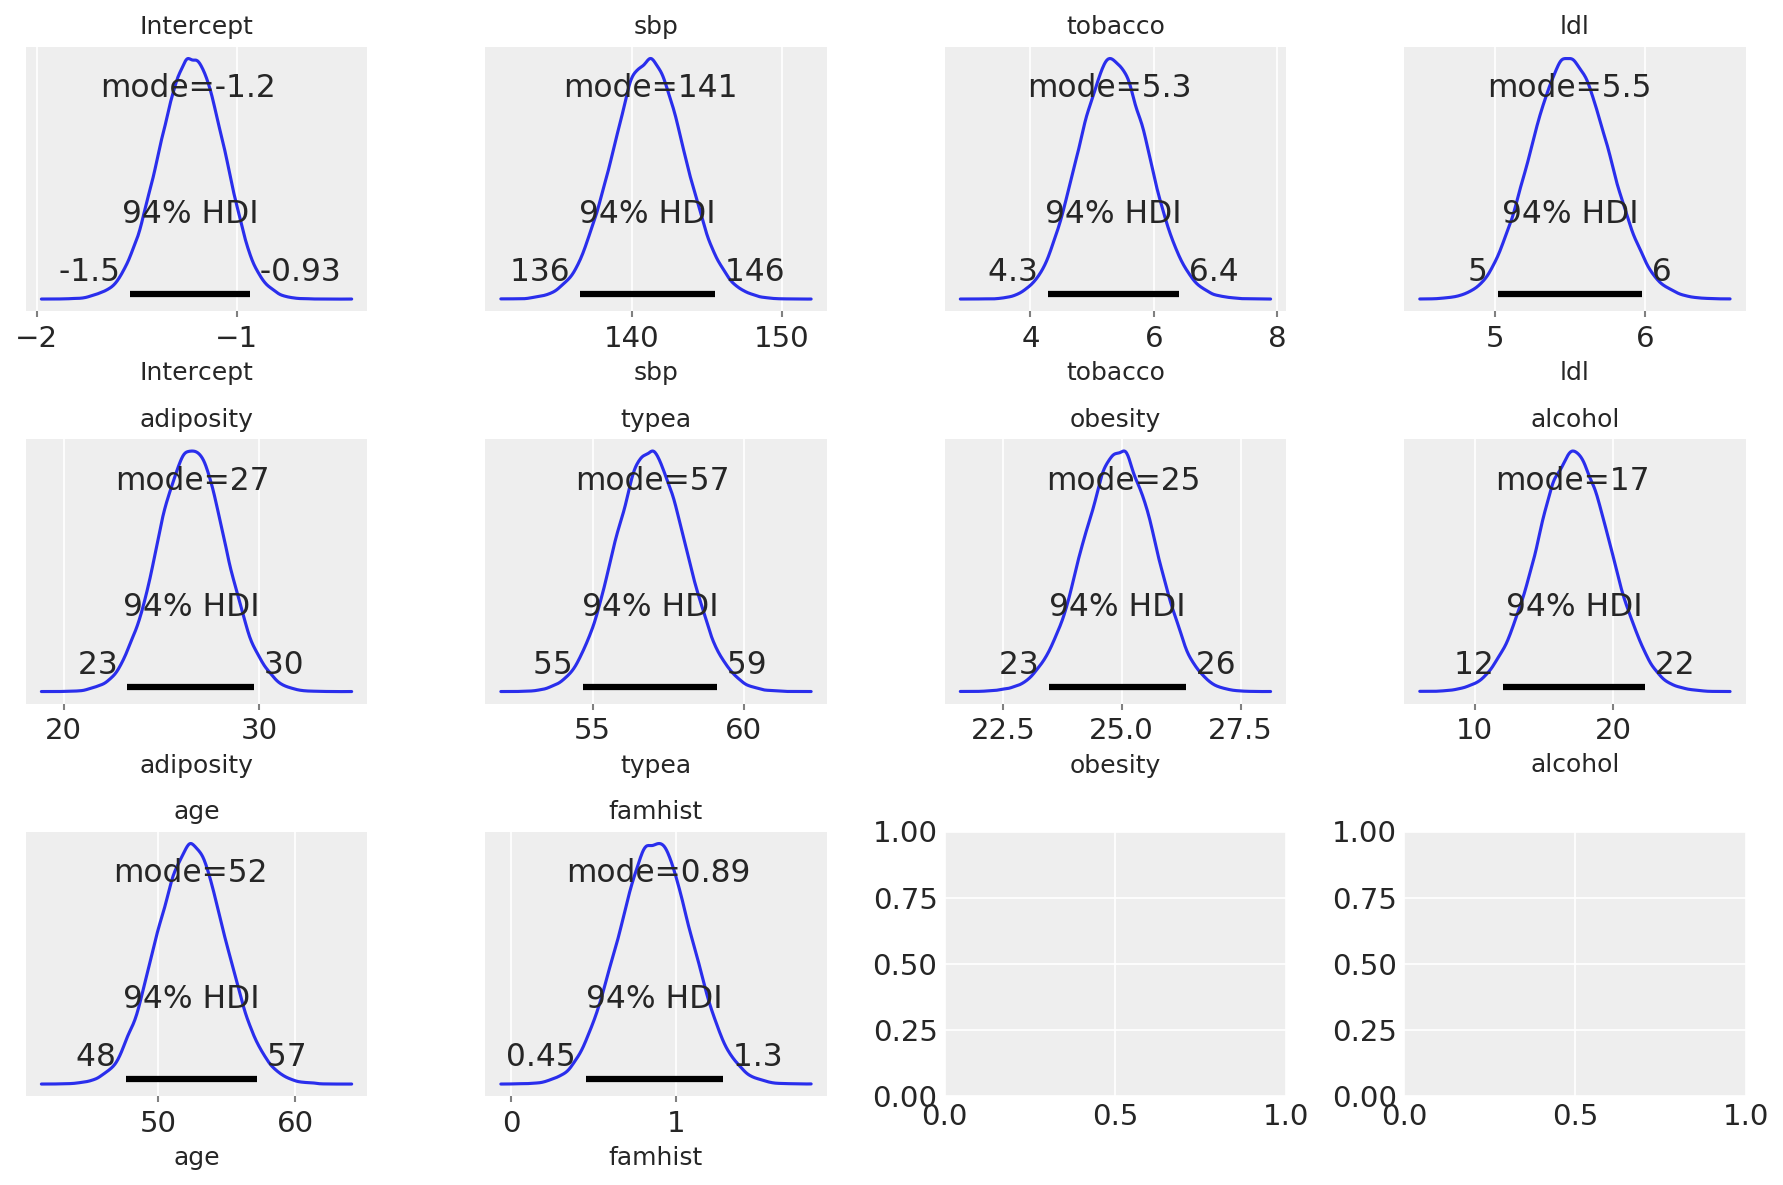

In [17]:
# Not required but additional plots of the coefficients
# Transform parameters back to original scale
burnin = 100
intercept = trace_main['β0'][burnin:]
beta = trace_main['β'][burnin:]
for i in range(k-1):
    beta[:, i] = beta[:, i] * std[i] + mean[i]

# Plot posteriors

fig, axes = plt.subplots(3,4, figsize=(12,8), dpi=150)

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept] + [beta[:,i] for i in range(k)],
                               ['Intercept'] + all_predictors,
                               ['Intercept'] + all_predictors):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

plt.tight_layout()

## Problem 4

With the data set bangladesh.csv develop a pooled, a no-pooled, and a hierarchical model for all districts to predict contraception usage. Use only district and age.centered as predictor variables. Plot each of these predictions with age.centered on the x-axis and the expected proportion of women using contraception on the y-Axis with overlaid plots for the districts. Briefly explain these results.


In [18]:
path = "/Users/donaldbrown/Dropbox/department/Classes/Data/"
file = "bangladesh.csv"
data = pd.read_csv(path+file)
# Predictor variables
age = data['age.centered']
contraception = data['use.contraception']
# grouping or hierarchical variable
districts = data['district'].unique()
ndistricts = len(districts)

In [19]:
data.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


In [20]:
# Load data

path = "/Users/donaldbrown/Dropbox/department/Classes/Data/"
file = "bangladesh.csv"
data = pd.read_csv(path+file)
# Predictor variables
age = data['age.centered']
contraception = data['use.contraception']
# grouping or hierarchical variable
districts = data['district'].unique()
ndistricts = len(districts)

# lookup table (dict) for each district
district_lookup = dict(zip(districts, range(ndistricts)))
district  = data["district_code"] = data.district.replace(district_lookup).values

In [21]:
# Complete pooling model

with pm.Model() as pooled_model:
    β = pm.Normal('β', 0, sd=1e5, shape=2)
    μ = β[0] + β[1]*age
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=contraception) 
    # Run sampling
    pooled_trace = pm.sample(10000, cores = 4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.


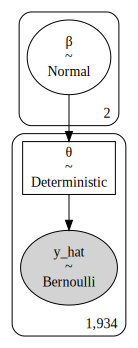

In [22]:
# Graph of pooled model

pm.model_to_graphviz(pooled_model)

In [23]:
# Summary of results
with pooled_model:
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2, var_names = ['β'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β[0],-0.44,0.05,-0.53,-0.35,0.0,0.0,36639.31,36226.29,36657.25,28764.25,1.0
β[1],0.01,0.01,-0.00,0.02,0.0,0.0,36469.42,31607.42,36476.30,30945.74,1.0


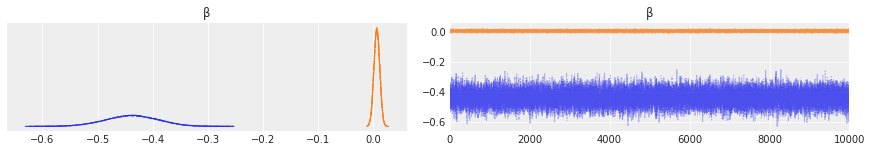

In [24]:
with pooled_model:
    pm.traceplot(pooled_trace, var_names = ['β'])

In [25]:
# Logistic

def logistic(x):
    return ( 1 / (1+ np.exp(-x)))

Text(0.5, 1.0, 'Pooled Model')

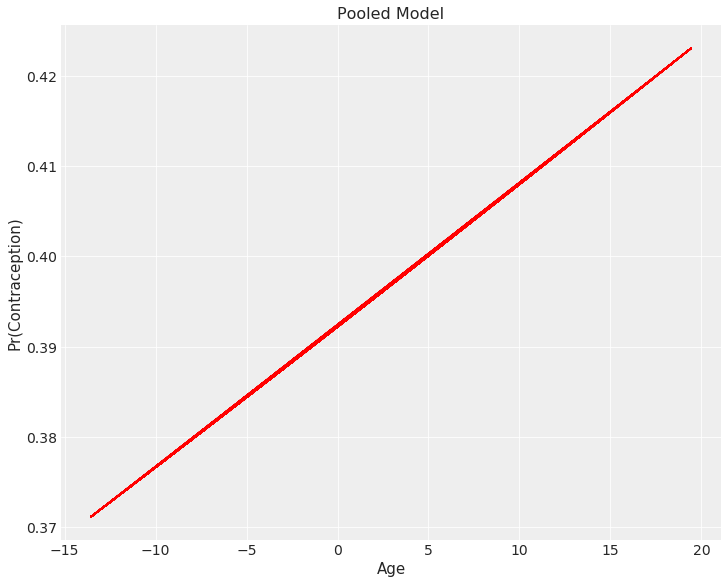

In [26]:
# Plot of the pooled model
beta = np.mean(pooled_trace['β'], axis=0)
plt.figure(figsize = (10,8))
#plt.scatter(age, contraception)
#xvals = np.linspace(-20, 20)
plt.plot(age, logistic(beta[0] + beta[1]*age), 'r--');
plt.xlabel("Age")
plt.ylabel("Pr(Contraception)")
plt.title("Pooled Model")

In [27]:
# Unpooled Model

with pm.Model() as unpooled_model:
    
    β0 = pm.Normal('β0', 0, sd=100, shape=ndistricts)
    β1 = pm.Normal('β1', 0, sd=100)
    
    μ = β0[district] + β1*age
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=contraception)
    
    # Sample the posterior
    unpooled_trace = pm.sample(draws=1000, cores =8)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [β1, β0]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.
There were 804 divergences after tuning. Increase `target_accept` or reparameterize.
There were 867 divergences after tuning. Increase `target_accept` or reparameterize.
There were 936 divergences after tuning. Increase `target_accept` or reparameterize.
There were 842 divergences after tuning. Increase `target_accept` or reparameterize.
There were 879 divergences after tuning. Increase `target_accept` or reparameterize.
There were 953 divergences after tuning. Increase `target_accept` or reparameterize.
There were 894 divergences after tuning. Increase `target_accept` or reparameterize.
There were 924 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


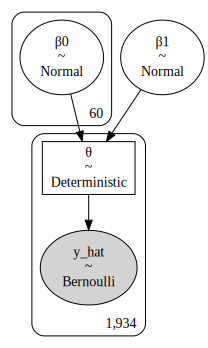

In [28]:
# Graph the unpooled model
pm.model_to_graphviz(unpooled_model)

In [29]:
# Summary of results
with unpooled_model:
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(unpooled_idata, round_to=2, var_names = ['β0','β1'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0[0],-1.08,0.22,-1.48,-0.67,0.01,0.00,1297.55,1261.09,1304.94,2038.99,1.01
β0[1],-0.65,0.48,-1.58,0.26,0.01,0.01,1093.54,1093.54,1093.68,1452.68,1.01
β0[2],81.69,60.26,1.37,189.90,2.35,1.76,656.56,583.69,872.70,926.49,1.01
β0[3],-0.01,0.37,-0.70,0.70,0.01,0.01,1152.71,1152.71,1155.80,1742.18,1.01
β0[4],-0.59,0.34,-1.24,0.05,0.01,0.01,1173.68,1044.98,1200.93,1398.50,1.01
β0[5],-0.90,0.28,-1.45,-0.41,0.01,0.01,1207.59,1204.74,1212.89,1597.64,1.01
β0[6],-0.97,0.55,-1.99,0.10,0.02,0.01,1275.31,1240.91,1283.74,1581.09,1.00
β0[7],-0.51,0.35,-1.18,0.13,0.01,0.01,1294.56,1294.56,1295.96,1311.70,1.01
β0[8],-0.85,0.47,-1.75,0.00,0.01,0.01,1052.67,1007.62,1070.03,1163.52,1.01
β0[9],-3.08,1.40,-5.47,-0.83,0.06,0.05,573.65,400.98,913.32,640.33,1.01


Text(0.5, 1.0, 'Unpooled Model')

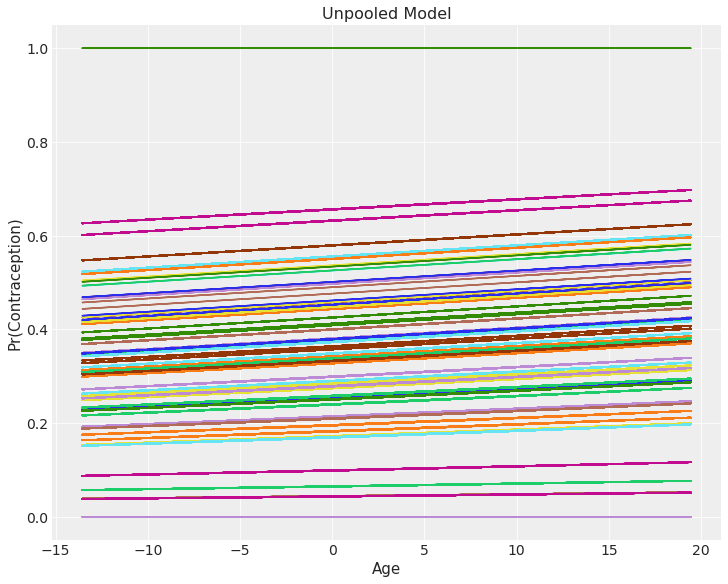

In [30]:
# Plot of the unpooled model
beta0 = np.mean(unpooled_trace['β0'], axis=0)
beta1 = np.mean(unpooled_trace['β1'], axis=0)
plt.figure(figsize = (10,8))
for beta0i in beta0:
    plt.plot(age, logistic(beta0i + beta1*age))

plt.xlabel("Age")
plt.ylabel("Pr(Contraception)")
plt.title("Unpooled Model")

<Figure size 432x1008 with 0 Axes>

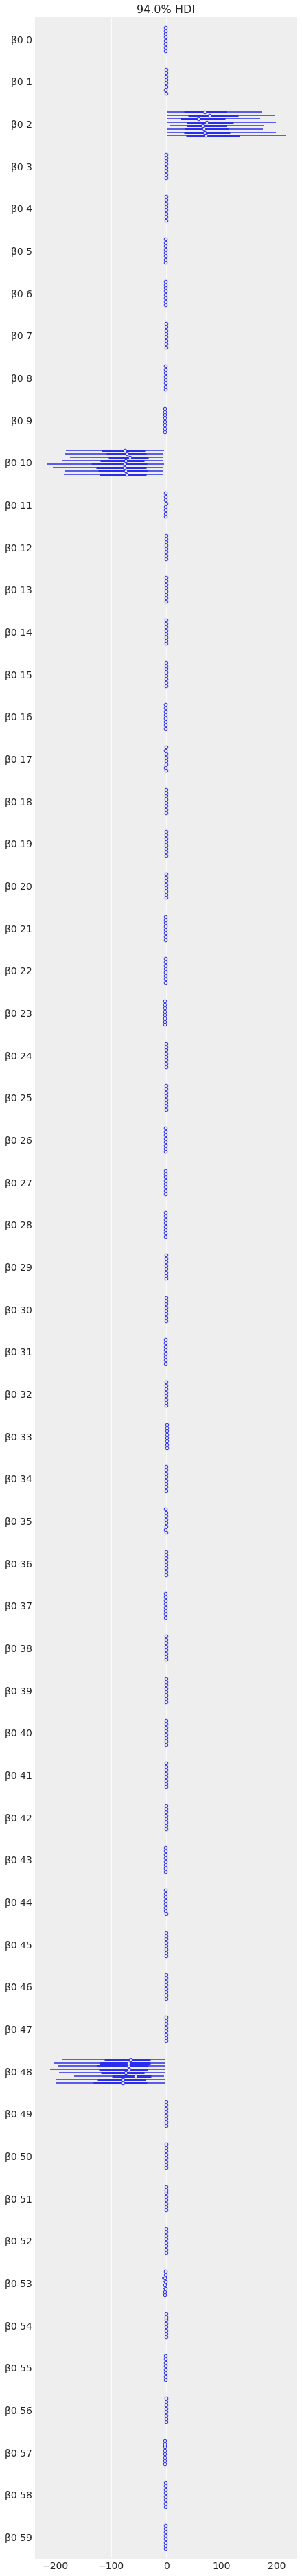

In [31]:
# Forest plots
plt.figure(figsize=(6,14))
with unpooled_model:
    pm.forestplot(unpooled_trace, var_names=['β0']);

Notice from these forest plots that some of the districs are underpopulated and not able to support estimates. Also notice in the plots of the logistic function for each district that they are highly variable and one of them is actually providing predicted probability of 1 for all ages.

In [32]:
with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=ndistricts)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=ndistricts)
    
    # Linear model
    μ = a[district] + b[district]*age
    
    # Transform outcome to probability
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=contraception)
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=1000, step=pm.NUTS(target_accept=0.99), tune=5000)



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, sigma_a, mu_b, mu_a]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 328 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


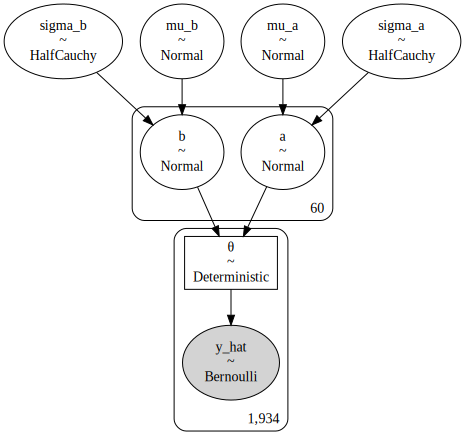

In [34]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_model)

In [35]:
# Summary of results
with hierarchical_model:
    hierarchical_idata = az.from_pymc3(hierarchical_trace)
az.summary(hierarchical_idata, round_to=2, var_names = ['a','b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.01,0.20,-1.40,-0.65,0.00,0.00,5645.36,5194.50,5672.83,2877.51,1.00
a[1],-0.59,0.35,-1.27,0.05,0.00,0.00,5655.94,3654.89,5630.90,3075.03,1.00
a[2],-0.22,0.51,-1.15,0.74,0.01,0.01,6123.19,2231.12,6229.95,2972.74,1.00
a[3],-0.19,0.31,-0.79,0.39,0.00,0.01,7526.04,1968.55,7493.57,2416.41,1.00
a[4],-0.58,0.29,-1.09,-0.01,0.00,0.00,6683.67,4747.62,6714.48,2758.87,1.00
a[5],-0.83,0.24,-1.28,-0.41,0.00,0.00,6898.73,5480.08,6922.38,3029.69,1.00
a[6],-0.75,0.38,-1.47,-0.07,0.00,0.00,6268.51,3968.95,6423.09,2805.04,1.00
a[7],-0.51,0.29,-1.09,-0.01,0.00,0.00,7579.96,4247.71,7521.55,2597.99,1.00
a[8],-0.72,0.34,-1.36,-0.07,0.00,0.00,6218.04,4685.99,6240.50,3098.06,1.00
a[9],-1.18,0.45,-2.06,-0.37,0.01,0.01,4024.13,2891.62,4401.00,2388.84,1.00


<Figure size 432x1008 with 0 Axes>

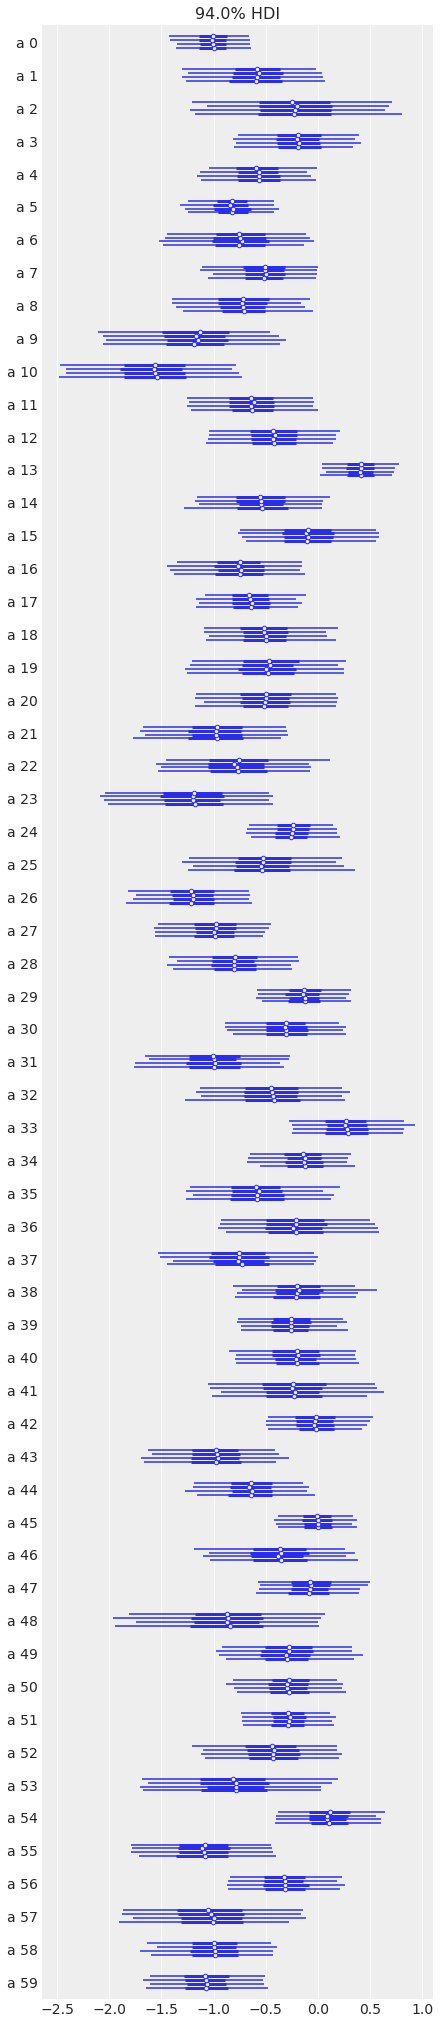

In [36]:
# Forest plots for intercepts
plt.figure(figsize=(6,14))
with hierarchical_model:
    pm.forestplot(hierarchical_trace, var_names=['a']);

<Figure size 432x1008 with 0 Axes>

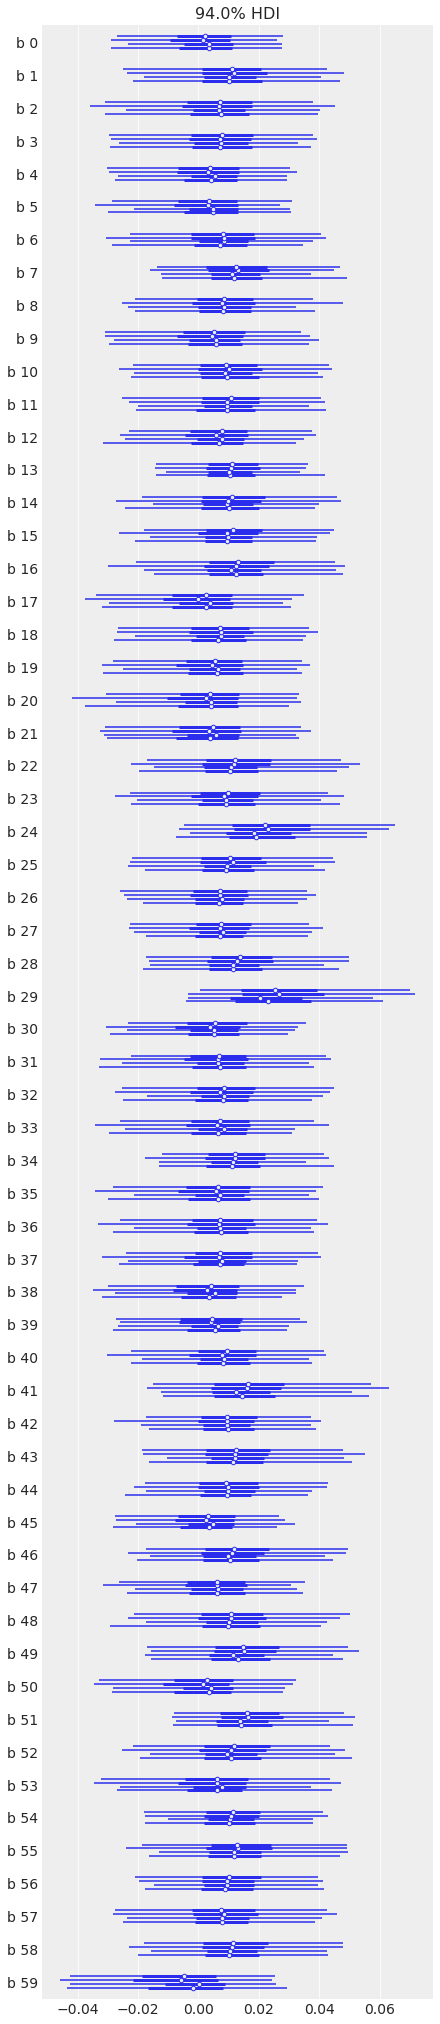

In [37]:
# Forest plots for slopes
plt.figure(figsize=(6,14))
with hierarchical_model:
    pm.forestplot(hierarchical_trace, var_names=['b']);

Text(0.5, 1.0, 'Hierarchical Model')

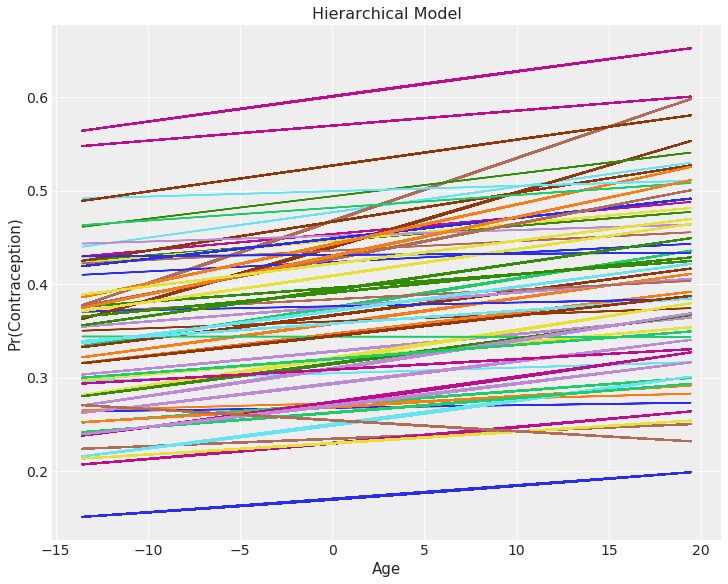

In [38]:
# Plot of the hierarchical model
intercepts = np.mean(hierarchical_trace['a'], axis=0)
slopes = np.mean(hierarchical_trace['b'], axis=0)
plt.figure(figsize = (10,8))
for ai, bi in zip(intercepts, slopes):
    plt.plot(age, logistic(ai + bi*age))

plt.xlabel("Age")
plt.ylabel("Pr(Contraception)")
plt.title("Hierarchical Model")

We can compare the probability of contraception for each of the models. For the pooled model this probability is 0.37 for the younger women and 0.42 for the older women regarless of district. In the unpooled model for one district this probability is 1.0 regardless of age, while in another district it is 0.0 regardless of age. Clearly these are not reasonable.  The hiearchical model provides models for each district with none that have extreme values due to the small sample size in the district. Probabilities of contraception use range from less than 0.2 (but greater than 0.1) in the district with the least useage to a range of (0.58, 0.62) in the district with the most useage.  

The forest plots show than none of the slope parameters are statistically significant at p < 0.05.  

## Problem 5

For the CHD data in problem 3, develop two other models with fewer predictor variables and/or with a nonlinear transformation of one  of the the predictor variables. 

- Use WAIC to recommend which of these models to use.
- Use WAIC to produce a Bayesian model average result. Show the kernel density plots for the sample posterior predictions of each of the models and the Bayesian model average. 
- (5 points extra credit) Show the overlaid plots of the predictions for the data points in the CHDdata.csv file with age on the x-axis and the predicted probability on the y-axis. Overlay these results for each model and for  the Bayesian model average of the models.

In [39]:
# The CHD Data reloaded 
# Load the data

path = "/Users/donaldbrown/Dropbox/department/Classes/Data/"
file = "CHDdata.csv"
data = pd.read_csv(path+file)

# Numeric predictors
numeric_predictors = ["sbp","tobacco","ldl","adiposity","typea","obesity","alcohol","age"]
n = data.shape[0]

# Numeric, categorical predictors and response, y`

x_num = data[numeric_predictors]
x_cat = data['famhist']
y = data['chd']

all_predictors = numeric_predictors
all_predictors.append('famhist')

# No. of predictors
k = len(all_predictors)

# Standardize numeric columns, to mean 0 variance 1
mean = x_num.mean()
std = x_num.std()
x_num = np.array((x_num - mean) / std)

# Convert categorical predictor column to a dummy variable
# + 0 forces numeric type
x_cat = np.array(data['famhist'] == 'Present').reshape((n,1))

# Put them into one data matrix

X = np.concatenate((x_num, x_cat), axis = 1)

In [41]:
# Model 2 (Model 1 is the earlier main effects model)
# A simple model without sdp, adiposity, and alcohol (see earlier forest plots)

X_simple = np.delete(X, np.s_[0,3,6], axis=1) 
k_simple = X_simple.shape[1]

with pm.Model() as chd_simple_model:
    
    # Intercept term & prior
    β0 = pm.Normal('β0', mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k_simple), cov=np.eye(k_simple), shape=k_simple)
    
    
    # Calculate the logit 
    μ = β0 + pm.math.dot(X_simple,β)
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=y) 
    
    # Sample
    trace_simple = pm.sample(10000, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [β, β0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 65 seconds.


In [42]:
# Model 3
# A model with only obesity and age
# numeric_predictors = ["sbp","tobacco","ldl","adiposity","typea","obesity","alcohol","age"]
X_tiny = X[:,[5,7]] 
k_tiny = X_tiny.shape[1]


with pm.Model() as chd_tiny_model:
    
    # Intercept term & prior
    β0 = pm.Normal('β0', mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k_tiny), cov=np.eye(k_tiny), shape=k_tiny)
    
    
    # Calculate the logit 
    μ = β0 + pm.math.dot(X_tiny,β)
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=y) 
    
    # Sample
    trace_tiny = pm.sample(10000,  cores =8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [β, β0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 57 seconds.


In [43]:
# Results in table
with chd_simple_model:
    simple_idata = az.from_pymc3(trace_simple)
az.summary(simple_idata, var_names=['β0','β'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0,-1.22,0.16,-1.52,-0.92,0.0,0.0,72337.57,71149.85,72516.55,59874.46,1.0
β[0],0.37,0.12,0.15,0.60,0.0,0.0,86856.35,81917.84,87014.69,64911.15,1.0
β[1],0.38,0.12,0.16,0.61,0.0,0.0,89275.07,82995.00,89597.13,64854.80,1.0
β[2],0.37,0.12,0.14,0.59,0.0,0.0,87273.40,80966.94,87460.64,62919.55,1.0
β[3],-0.16,0.12,-0.39,0.07,0.0,0.0,84239.80,67309.81,84528.74,61634.69,1.0
β[4],0.76,0.15,0.49,1.04,0.0,0.0,79722.73,77508.61,79889.41,62680.96,1.0
β[5],0.86,0.22,0.45,1.28,0.0,0.0,75673.39,73808.68,75680.66,59848.27,1.0


In [44]:
# Results in table
with chd_tiny_model:
    tiny_idata = az.from_pymc3(trace_tiny)
az.summary(tiny_idata, var_names=['β0','β'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0,-0.77,0.11,-0.99,-0.56,0.0,0.0,88951.70,86835.13,89085.29,58927.31,1.0
β[0],0.01,0.11,-0.20,0.22,0.0,0.0,95968.74,40538.35,95914.81,60270.24,1.0
β[1],0.93,0.13,0.68,1.16,0.0,0.0,87933.08,86724.17,88042.60,61286.37,1.0


In [45]:
%%capture output

cmp_chd = az.compare({'chd_tiny_model':trace_tiny,'chd_model':trace_main,'chd_simple_model':trace_simple}, 
                     ic = 'WAIC',  scale='deviance')
cmp_chd

In [46]:
cmp_chd

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
chd_simple_model,0,487.944,6.88617,0,0.840914,17.6892,0,False,deviance
chd_model,1,492.481,10.053,4.53686,0.158276,21.4539,2.92197,False,deviance
chd_tiny_model,2,531.612,2.99695,43.6684,0.000809858,21.0392,13.7321,False,deviance


These results show that the simple model with variables "tobacco","ldl","typea","obesity","age" as predictors does the best on WAIC compared to either the main effect model or the simpler model with only two variables. 

In [47]:
#Posterior predicted values from each model and the BMA

# Main effects model
pred_main = pm.sample_posterior_predictive_w(traces=[trace_main],samples=10000, 
                                             models=[chd_model])
# Variable selected model - simple model
pred_simple = pm.sample_posterior_predictive_w(traces=[trace_simple], samples=10000,
                                               models=[chd_simple_model])
# Very reduced model - only 2 variables
pred_tiny = pm.sample_posterior_predictive_w(traces=[trace_tiny], samples=10000,
                                            models=[chd_tiny_model])
# BMA
pred_bma = pm.sample_posterior_predictive_w(traces=[trace_main, trace_simple, trace_tiny],
                                            samples=10000, models=[chd_model, chd_simple_model,chd_tiny_model],
                                            weights=cmp_chd['weight'])



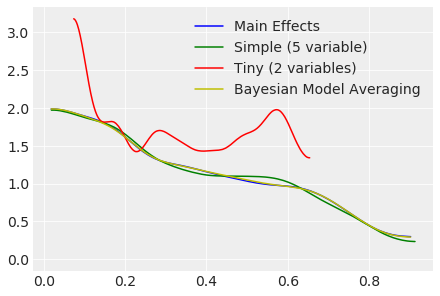

In [48]:
# Plot the kde of the predictions from each model
models = [pred_main, pred_simple, pred_tiny, pred_bma]
colors = ['b', 'g', 'r', 'y']
fig, ax = plt.subplots()
labels = ['Main Effects', 'Simple (5 variable)', 'Tiny (2 variables)', 'Bayesian Model Averaging']

for i, preds in enumerate(models):
    pm.plot_kde(preds['y_hat'].mean(0), plot_kwargs = {'color': colors[i]}, label=labels[i], ax=ax)

plt.show()

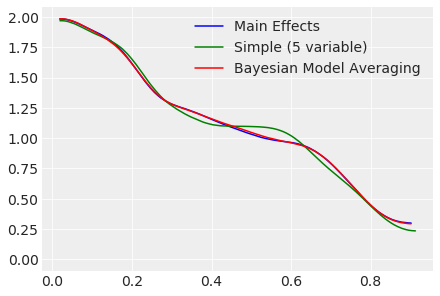

In [49]:
# Plot the kde of the predictions without the tiny model 
models = [pred_main, pred_simple,  pred_bma]
colors = ['b', 'g', 'r']
fig, ax = plt.subplots()
labels = ['Main Effects', 'Simple (5 variable)', 'Bayesian Model Averaging']

for i, preds in enumerate(models):
    pm.plot_kde(preds['y_hat'].mean(0), plot_kwargs = {'color': colors[i]}, label=labels[i], ax=ax)

plt.show()

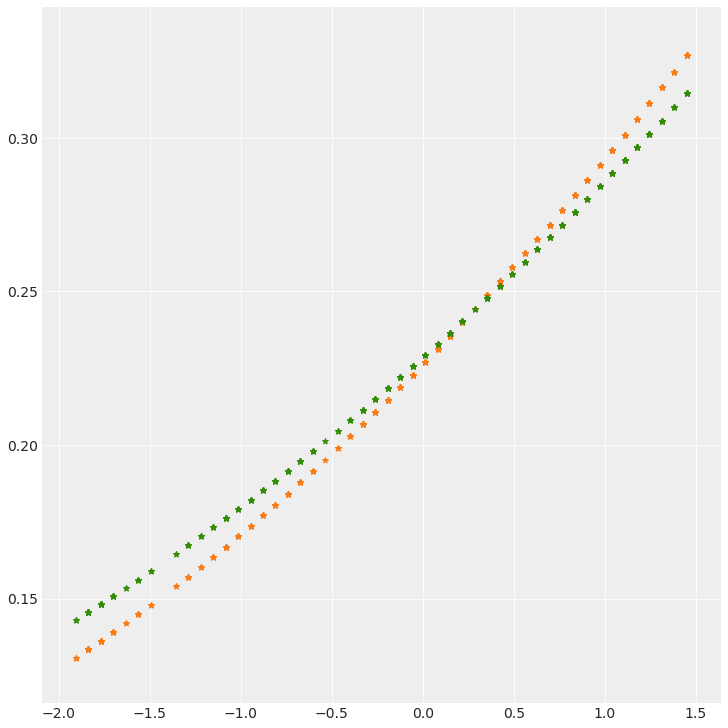

In [50]:
# Plot of the probability of CHD vs. age.
   
def Logistic(Lmodel):
    return np.exp(Lmodel)/(1+np.exp(Lmodel))
    
# Main effects plot
β0_main = trace_main['β0'].mean()
β_main = trace_main['β'][7].mean()
y_post_main = β0_main + β_main * X[:,7]

y_main = Logistic(y_post_main)
plt.figure(figsize = (10,10))
plt.scatter(X[:,7], y_main, marker = '*', color = 'C1', label='Main Effects')

# Simple, reduced model plot
β0_simple = trace_simple['β0'].mean()
β_simple = trace_simple['β'][4].mean()
y_post_simple = β0_simple + β_simple * X[:,7]

y_simple = Logistic(y_post_simple)
plt.scatter(X[:,7], y_simple, marker = '*', color = 'C2', label='Reduced Model')


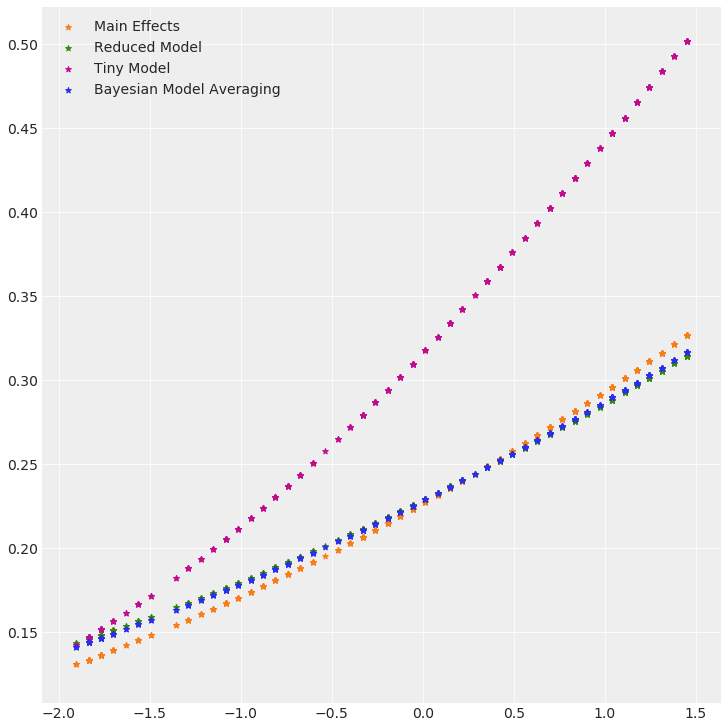

In [51]:
# Plot of the probability of CHD vs. age.
   
def Logistic(Lmodel):
    return np.exp(Lmodel)/(1+np.exp(Lmodel))
    
# Main effects plot
β0_main = trace_main['β0'].mean()
β_main = trace_main['β'][7].mean()
y_post_main = β0_main + β_main * X[:,7]

y_main = Logistic(y_post_main)
plt.figure(figsize = (10,10))
plt.scatter(X[:,7], y_main, marker = '*', color = 'C1', label='Main Effects')

# Simple, reduced model plot
β0_simple = trace_simple['β0'].mean()
β_simple = trace_simple['β'][4].mean()
y_post_simple = β0_simple + β_simple * X[:,7]

y_simple = Logistic(y_post_simple)
plt.scatter(X[:,7], y_simple, marker = '*', color = 'C2', label='Reduced Model')

# Tiny model plot
β0_tiny = trace_tiny['β0'].mean()
β_tiny = trace_tiny['β'][1].mean()
y_post_tiny = β0_tiny + β_tiny * X[:,7] 
y_tiny = Logistic(y_post_tiny)
plt.scatter(X[:,7], y_tiny, marker = '*', color = 'C3', label='Tiny Model')

# Bayesian Model Averaging

y_bma = cmp_chd['weight'][0]*y_simple + cmp_chd['weight'][1]*y_main + cmp_chd['weight'][2]*y_tiny

plt.scatter(X[:,7], y_bma, c='C0', marker='*', label = "Bayesian Model Averaging")
plt.legend()




## A version with an interaction model

In [52]:
# Model 3 
# An interaction model with age and obesity; age and ldl
# Interaction with age
# Interaction with age & obesity
Xint = np.array((X.T[3,:]*X.T[4,:]).T).reshape((X.shape[0],1))
#Combine the matrices

X_int = np.concatenate((X,Xint), axis = 1)
k_int = X_int.shape[1]

with pm.Model() as chd_int_model:
    
    # Intercept term & prior
    β0 = pm.Normal('β0', mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k_int), cov=np.eye(k_int), shape=k_int)
    
    
    # Calculate the logit 
    μ = β0 + pm.math.dot(X_int,β)
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=y) 
    
    # Sample
    trace_int = pm.sample(5000, step=pm.NUTS(target_accept=0.99), tune=10000, cores =8)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [β, β0]


Sampling 8 chains for 10_000 tune and 5_000 draw iterations (80_000 + 40_000 draws total) took 198 seconds.


In [53]:
%%capture output

cmp_chd = az.compare({'chd_model':trace_main,'chd_simple_model':trace_simple, 
                     'chd_int_model':trace_int}, ic = 'WAIC',
                    method='BB-pseudo-BMA', scale='deviance')
cmp_chd

In [54]:
cmp_chd

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
chd_simple_model,0,487.944,6.88617,0,0.790266,22.0066,0,False,deviance
chd_model,1,492.481,10.053,4.53686,0.142097,21.6207,2.92197,False,deviance
chd_int_model,2,494.232,11.0592,6.28783,0.0676372,22.2975,3.30814,False,deviance


These results show that the simple model with only "tobacco","ldl","typea","obesity","age" as predictors does the best on WAIC. 

In [55]:
#Posterior predicted values from each model and the BMA

# Main effects model
pred_main = pm.sample_posterior_predictive_w(traces=[trace_main],samples=10000, 
                                             models=[chd_model])
# Variable selected model - simple model
pred_simple = pm.sample_posterior_predictive_w(traces=[trace_simple], samples=10000,
                                               models=[chd_simple_model])
# Interaction model with the age variable
pred_int = pm.sample_posterior_predictive_w(traces=[trace_int], samples=10000,
                                            models=[chd_int_model])
# BMA
pred_bma = pm.sample_posterior_predictive_w(traces=[trace_main, trace_simple, trace_int],
                                            samples=10000, models=[chd_model, chd_simple_model,chd_int_model],
                                            weights=cmp_chd['weight'])



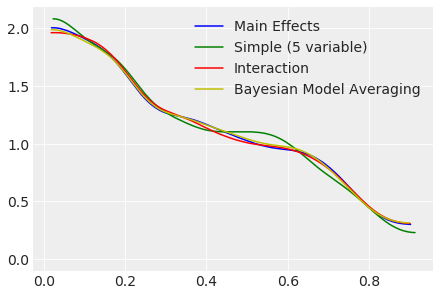

In [56]:
# Plot the kde of the predictions from each model
models = [pred_main, pred_simple, pred_int, pred_bma]
colors = ['b', 'g', 'r', 'y']
fig, ax = plt.subplots()
labels = ['Main Effects', 'Simple (5 variable)', 'Interaction', 'Bayesian Model Averaging']

for i, preds in enumerate(models):
    pm.plot_kde(preds['y_hat'].mean(0), plot_kwargs = {'color': colors[i]}, label=labels[i], ax=ax)

plt.show()

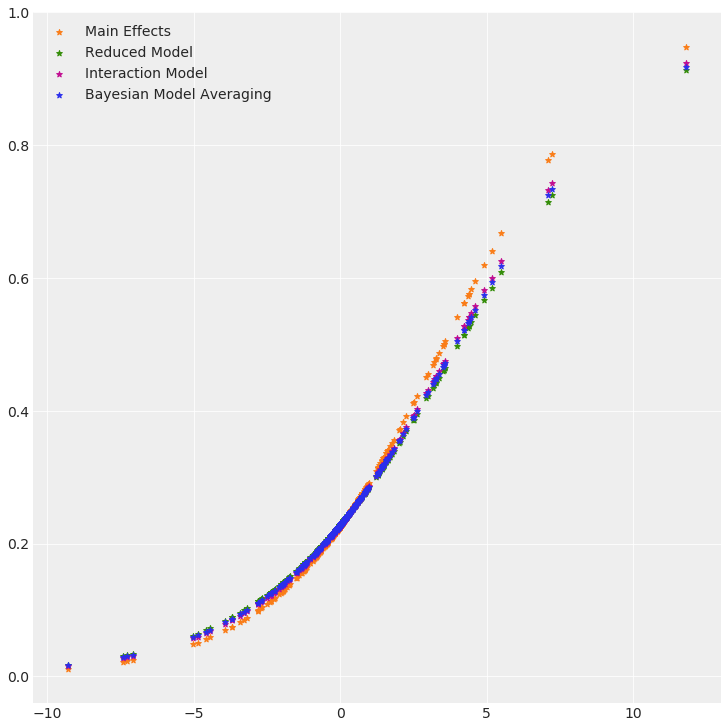

In [66]:
# Plot of the probability of CHD vs. age.
   
def Logistic(Lmodel):
    return np.exp(Lmodel)/(1+np.exp(Lmodel))
    
# Main effects plot
β0_main = trace_main['β0'].mean()
β_main = trace_main['β'][7].mean()
y_post_main = β0_main + β_main * X[:,7]

y_main = Logistic(y_post_main)
plt.figure(figsize = (10,10))
plt.scatter(X[:,7], y_main, marker = '*', color = 'C1', label='Main Effects')

# Simple, reduced model plot
β0_simple = trace_simple['β0'].mean()
β_simple = trace_simple['β'][4].mean()
y_post_simple = β0_simple + β_simple * X[:,7]

y_simple = Logistic(y_post_simple)
plt.scatter(X[:,7], y_simple, marker = '*', color = 'C2', label='Reduced Model')

# Interaction model plot
β0_int = trace_int['β0'].mean()
β_int = trace_int['β'][4].mean()
β2_int = trace_int['β'][5].mean()
y_post_int = β0_int + β_int * X_int[:,7]# Assumes the obeisity value = 0, the mean.
y_int = Logistic(y_post_int)
plt.scatter(X[:,7], y_int, marker = '*', color = 'C3', label='Interaction Model')


# Bayesian Model Averaging

y_bma = cmp_chd['weight'][0]*y_simple + cmp_chd['weight'][1]*y_main + cmp_chd['weight'][2]*y_int

plt.scatter(X[:,7], y_bma, c='C0', marker='*', label = "Bayesian Model Averaging")
plt.legend()
